# Environment and Distribution Shift
:label:`sec_environment-and-distribution-shift`

In the previous sections, we worked through
a number of hands-on applications of machine learning,
fitting models to a variety of datasets.
And yet, we never stopped to contemplate
either where data comes from in the first place
or what we plan to ultimately do
with the outputs from our models.
Too often, machine learning developers
in possession of data rush to develop models
without pausing to consider these fundamental issues.

Many failed machine learning deployments
can be traced back to this pattern.
Sometimes models appear to perform marvelously
as measured by test set accuracy
but fail catastrophically in deployment
when the distribution of data suddenly shifts.
More insidiously, sometimes the very deployment of a model
can be the catalyst that perturbs the data distribution.
Say, for example, that we trained a model
to predict who will repay vs. default on a loan,
finding that an applicant's choice of footwear
was associated with the risk of default
(Oxfords indicate repayment, sneakers indicate default).
We might be inclined to thereafter grant loans
to all applicants wearing Oxfords
and to deny all applicants wearing sneakers.

In this case, our ill-considered leap from
pattern recognition to decision-making
and our failure to critically consider the environment
might have disastrous consequences.
For starters, as soon as we began
making decisions based on footwear,
customers would catch on and change their behavior.
Before long, all applicants would be wearing Oxfords,
without any coinciding improvement in credit-worthiness.
Take a minute to digest this because similar issues abound
in many applications of machine learning:
by introducing our model-based decisions to the environment,
we might break the model.

While we cannot possibly give these topics
a complete treatment in one section,
we aim here to expose some common concerns,
and to stimulate the critical thinking
required to detect these situations early,
mitigate damage, and use machine learning responsibly.
Some of the solutions are simple
(ask for the "right" data),
some are technically difficult
(implement a reinforcement learning system),
and others require that we step outside the realm of
statistical prediction altogether and
grapple with difficult philosophical questions
concerning the ethical application of algorithms.

## Types of Distribution Shift

To begin, we stick with the passive prediction setting
considering the various ways that data distributions might shift
and what might be done to salvage model performance.
In one classic setup, we assume that our training data
was sampled from some distribution $p_S(\mathbf{x},y)$
but that our test data will consist
of unlabeled examples drawn from
some different distribution $p_T(\mathbf{x},y)$.
Already, we must confront a sobering reality.
Absent any assumptions on how $p_S$
and $p_T$ relate to each other,
learning a robust classifier is impossible.

Consider a binary classification problem,
where we wish to distinguish between dogs and cats.
If the distribution can shift in arbitrary ways,
then our setup permits the pathological case
in which the distribution over inputs remains
constant: $p_S(\mathbf{x}) = p_T(\mathbf{x})$,
but the labels are all flipped:
$p_S(y \mid \mathbf{x}) = 1 - p_T(y \mid \mathbf{x})$.
In other words, if God can suddenly decide
that in the future all "cats" are now dogs
and what we previously called "dogs" are now cats---without
any change in the distribution of inputs $p(\mathbf{x})$,
then we cannot possibly distinguish this setting
from one in which the distribution did not change at all.

Fortunately, under some restricted assumptions
on the ways our data might change in the future,
principled algorithms can detect shift
and sometimes even adapt on the fly,
improving on the accuracy of the original classifier.

### Covariate Shift

Among categories of distribution shift,
covariate shift may be the most widely studied.
Here, we assume that while the distribution of inputs
may change over time, the labeling function,
i.e., the conditional distribution
$P(y \mid \mathbf{x})$ does not change.
Statisticians call this *covariate shift*
because the problem arises due to a
shift in the distribution of the covariates (features).
While we can sometimes reason about distribution shift
without invoking causality, we note that covariate shift
is the natural assumption to invoke in settings
where we believe that $\mathbf{x}$ causes $y$.

Consider the challenge of distinguishing cats and dogs.
Our training data might consist of images of the kind in :numref:`fig_cat-dog-train`.

![Training data for distinguishing cats and dogs.](../img/cat-dog-train.svg)
:label:`fig_cat-dog-train`


At test time we are asked to classify the images in :numref:`fig_cat-dog-test`.

![Test data for distinguishing cats and dogs.](../img/cat-dog-test.svg)
:label:`fig_cat-dog-test`

The training set consists of photos,
while the test set contains only cartoons.
Training on a dataset with substantially different
characteristics from the test set
can spell trouble absent a coherent plan
for how to adapt to the new domain.

### Label Shift

*Label shift* describes the converse problem.
Here, we assume that the label marginal $P(y)$
can change
but the class-conditional distribution
$P(\mathbf{x} \mid y)$ remains fixed across domains.
Label shift is a reasonable assumption to make
when we believe that $y$ causes $\mathbf{x}$.
For example, we may want to predict diagnoses
given their symptoms (or other manifestations),
even as the relative prevalence of diagnoses
are changing over time.
Label shift is the appropriate assumption here
because diseases cause symptoms.
In some degenerate cases the label shift
and covariate shift assumptions can hold simultaneously.
For example, when the label is deterministic,
the covariate shift assumption will be satisfied,
even when $y$ causes $\mathbf{x}$.
Interestingly, in these cases,
it is often advantageous to work with methods
that flow from the label shift assumption.
That is because these methods tend
to involve manipulating objects that look like labels (often low-dimensional),
as opposed to objects that look like inputs,
which tend to be high-dimensional in deep learning.

### Concept Shift

We may also encounter the related problem of *concept shift*,
which arises when the very definitions of labels can change.
This sounds weird---a *cat* is a *cat*, no?
However, other categories are subject to changes in usage over time.
Diagnostic criteria for mental illness,
what passes for fashionable, and job titles,
are all subject to considerable
amounts of concept shift.
It turns out that if we navigate around the United States,
shifting the source of our data by geography,
we will find considerable concept shift regarding
the distribution of names for *soft drinks*
as shown in :numref:`fig_popvssoda`.

![Concept shift on soft drink names in the United States.](../img/popvssoda.png)
:width:`400px`
:label:`fig_popvssoda`

If we were to build a machine translation system,
the distribution $P(y \mid \mathbf{x})$ might be different
depending on our location.
This problem can be tricky to spot.
We might hope to exploit knowledge
that shift only takes place gradually
either in a temporal or geographic sense.

## Examples of Distribution Shift

Before delving into formalism and algorithms,
we can discuss some concrete situations
where covariate or concept shift might not be obvious.


### Medical Diagnostics

Imagine that you want to design an algorithm to detect cancer.
You collect data from healthy and sick people
and you train your algorithm.
It works fine, giving you high accuracy
and you conclude that you are ready
for a successful career in medical diagnostics.
*Not so fast.*

The distributions that gave rise to the training data
and those you will encounter in the wild might differ considerably.
This happened to an unfortunate startup
that some of us (authors) worked with years ago.
They were developing a blood test for a disease
that predominantly affects older men
and hoped to study it using blood samples
that they had collected from patients.
However, it is considerably more difficult
to obtain blood samples from healthy men
than sick patients already in the system.
To compensate, the startup solicited
blood donations from students on a university campus
to serve as healthy controls in developing their test.
Then they asked whether we could help them
to build a classifier for detecting the disease.

As we explained to them,
it would indeed be easy to distinguish
between the healthy and sick cohorts
with near-perfect accuracy.
However, that is because the test subjects
differed in age, hormone levels,
physical activity, diet, alcohol consumption,
and many more factors unrelated to the disease.
This was unlikely to be the case with real patients.
Due to their sampling procedure,
we could expect to encounter extreme covariate shift.
Moreover, this case was unlikely to be
correctable via conventional methods.
In short, they wasted a significant sum of money.



### Self-Driving Cars

Say a company wanted to leverage machine learning
for developing self-driving cars.
One key component here is a roadside detector.
Since real annotated data is expensive to get,
they had the (smart and questionable) idea
to use synthetic data from a game rendering engine
as additional training data.
This worked really well on "test data"
drawn from the rendering engine.
Alas, inside a real car it was a disaster.
As it turned out, the roadside had been rendered
with a very simplistic texture.
More importantly, *all* the roadside had been rendered
with the *same* texture and the roadside detector
learned about this "feature" very quickly.

A similar thing happened to the US Army
when they first tried to detect tanks in the forest.
They took aerial photographs of the forest without tanks,
then drove the tanks into the forest
and took another set of pictures.
The classifier appeared to work *perfectly*.
Unfortunately, it had merely learned
how to distinguish trees with shadows
from trees without shadows---the first set
of pictures was taken in the early morning,
the second set at noon.

### Nonstationary Distributions

A much more subtle situation arises
when the distribution changes slowly
(also known as *nonstationary distribution*)
and the model is not updated adequately.
Below are some typical cases.

* We train a computational advertising model and then fail to update it frequently (e.g., we forget to incorporate that an obscure new device called an iPad was just launched).
* We build a spam filter. It works well at detecting all spam that we have seen so far. But then the spammers wisen up and craft new messages that look unlike anything we have seen before.
* We build a product recommendation system. It works throughout the winter but then continues to recommend Santa hats long after Christmas.

### More Anecdotes

* We build a face detector. It works well on all benchmarks. Unfortunately it fails on test data---the offending examples are close-ups where the face fills the entire image (no such data was in the training set).
* We build a Web search engine for the US market and want to deploy it in the UK.
* We train an image classifier by compiling a large dataset where each among a large set of classes is equally represented in the dataset, say 1000 categories, represented by 1000 images each. Then we deploy the system in the real world, where the actual label distribution of photographs is decidedly non-uniform.






## Correction of Distribution Shift

As we have discussed, there are many cases
where training and test distributions
$P(\mathbf{x}, y)$ are different.
In some cases, we get lucky and the models work
despite covariate, label, or concept shift.
In other cases, we can do better by employing
principled strategies to cope with the shift.
The remainder of this section grows considerably more technical.
The impatient reader could continue on to the next section
as this material is not prerequisite to subsequent concepts.

### Empirical Risk and  Risk
:label:`subsec_empirical-risk-and-risk`

Let's first reflect about what exactly
is happening during model training:
we iterate over features and associated labels
of training data
$\{(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\}$
and update the parameters of a model $f$ after every minibatch.
For simplicity we do not consider regularization,
so we largely minimize the loss on the training:

$$\mathop{\mathrm{minimize}}_f \frac{1}{n} \sum_{i=1}^n l(f(\mathbf{x}_i), y_i),$$
:eqlabel:`eq_empirical-risk-min`

where $l$ is the loss function
measuring "how bad" the prediction $f(\mathbf{x}_i)$ is given the associated label $y_i$.
Statisticians call the term in :eqref:`eq_empirical-risk-min` *empirical risk*.
The *empirical risk* is an average loss over the training data
to approximate the *risk*,
which is the
expectation of the loss over the entire population of data drawn from their true distribution
$p(\mathbf{x},y)$:

$$E_{p(\mathbf{x}, y)} [l(f(\mathbf{x}), y)] = \int\int l(f(\mathbf{x}), y) p(\mathbf{x}, y) \;d\mathbf{x}dy.$$
:eqlabel:`eq_true-risk`

However, in practice we typically cannot obtain the entire population of data.
Thus, *empirical risk minimization*,
which is minimizing the empirical risk in :eqref:`eq_empirical-risk-min`,
is a practical strategy for machine learning,
with the hope to approximate
minimizing the risk.



### Covariate Shift Correction
:label:`subsec_covariate-shift-correction`

Assume that we want to estimate
some dependency $P(y \mid \mathbf{x})$
for which we have labeled data $(\mathbf{x}_i, y_i)$.
Unfortunately, the observations $\mathbf{x}_i$ are drawn
from some *source distribution* $q(\mathbf{x})$
rather than the *target distribution* $p(\mathbf{x})$.
Fortunately,
the dependency assumption means
that the conditional distribution does not change: $p(y \mid \mathbf{x}) = q(y \mid \mathbf{x})$.
If the source distribution $q(\mathbf{x})$ is "wrong",
we can correct for that by using the following simple identity in the risk:

$$
\begin{aligned}
\int\int l(f(\mathbf{x}), y) p(y \mid \mathbf{x})p(\mathbf{x}) \;d\mathbf{x}dy =
\int\int l(f(\mathbf{x}), y) q(y \mid \mathbf{x})q(\mathbf{x})\frac{p(\mathbf{x})}{q(\mathbf{x})} \;d\mathbf{x}dy.
\end{aligned}
$$

In other words, we need to reweigh each data example
by the ratio of the
probability
that it would have been drawn from the correct distribution to that from the wrong one:

$$\beta_i \stackrel{\mathrm{def}}{=} \frac{p(\mathbf{x}_i)}{q(\mathbf{x}_i)}.$$

Plugging in the weight $\beta_i$ for
each data example $(\mathbf{x}_i, y_i)$
we can train our model using
*weighted empirical risk minimization*:

$$\mathop{\mathrm{minimize}}_f \frac{1}{n} \sum_{i=1}^n \beta_i l(f(\mathbf{x}_i), y_i).$$
:eqlabel:`eq_weighted-empirical-risk-min`



Alas, we do not know that ratio,
so before we can do anything useful we need to estimate it.
Many methods are available,
including some fancy operator-theoretic approaches
that attempt to recalibrate the expectation operator directly
using a minimum-norm or a maximum entropy principle.
Note that for any such approach, we need samples
drawn from both distributions---the "true" $p$, e.g.,
by access to test data, and the one used
for generating the training set $q$ (the latter is trivially available).
Note however, that we only need features $\mathbf{x} \sim p(\mathbf{x})$;
we do not need to access labels $y \sim p(y)$.

In this case, there exists a very effective approach
that will give almost as good results as the original: logistic regression,
which is a special case of softmax regression (see :numref:`sec_softmax`)
for binary classification.
This is all that is needed to compute estimated probability ratios.
We learn a classifier to distinguish
between data drawn from $p(\mathbf{x})$
and data drawn from $q(\mathbf{x})$.
If it is impossible to distinguish
between the two distributions
then it means that the associated instances
are equally likely to come from
either one of the two distributions.
On the other hand, any instances
that can be well discriminated
should be significantly overweighted
or underweighted accordingly.

For simplicity's sake assume that we have
an equal number of instances from both distributions
$p(\mathbf{x})$
and $q(\mathbf{x})$, respectively.
Now denote by $z$ labels that are $1$
for data drawn from $p$ and $-1$ for data drawn from $q$.
Then the probability in a mixed dataset is given by

$$P(z=1 \mid \mathbf{x}) = \frac{p(\mathbf{x})}{p(\mathbf{x})+q(\mathbf{x})} \text{ and hence } \frac{P(z=1 \mid \mathbf{x})}{P(z=-1 \mid \mathbf{x})} = \frac{p(\mathbf{x})}{q(\mathbf{x})}.$$

Thus, if we use a logistic regression approach,
where $P(z=1 \mid \mathbf{x})=\frac{1}{1+\exp(-h(\mathbf{x}))}$ ($h$ is a parameterized function),
it follows that

$$
\beta_i = \frac{1/(1 + \exp(-h(\mathbf{x}_i)))}{\exp(-h(\mathbf{x}_i))/(1 + \exp(-h(\mathbf{x}_i)))} = \exp(h(\mathbf{x}_i)).
$$

As a result, we need to solve two problems:
first one to distinguish between
data drawn from both distributions,
and then a weighted empirical risk minimization problem
in :eqref:`eq_weighted-empirical-risk-min`
where we weigh terms by $\beta_i$.

Now we are ready to describe a correction algorithm.
Suppose that we have a training set $\{(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\}$ and an unlabeled test set $\{\mathbf{u}_1, \ldots, \mathbf{u}_m\}$.
For covariate shift,
we assume that $\mathbf{x}_i$ for all $1 \leq i \leq n$ are drawn from some source distribution
and $\mathbf{u}_i$ for all $1 \leq i \leq m$
are drawn from the target distribution.
Here is a prototypical algorithm
for correcting covariate shift:

1. Generate a binary-classification training set: $\{(\mathbf{x}_1, -1), \ldots, (\mathbf{x}_n, -1), (\mathbf{u}_1, 1), \ldots, (\mathbf{u}_m, 1)\}$.
1. Train a binary classifier using logistic regression to get function $h$.
1. Weigh training data using $\beta_i = \exp(h(\mathbf{x}_i))$ or better $\beta_i = \min(\exp(h(\mathbf{x}_i)), c)$ for some constant $c$.
1. Use weights $\beta_i$ for training on $\{(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\}$ in :eqref:`eq_weighted-empirical-risk-min`.

Note that the above algorithm relies on a crucial assumption.
For this scheme to work, we need that each data example
in the target (e.g., test time) distribution
had nonzero probability of occurring at training time.
If we find a point where $p(\mathbf{x}) > 0$ but $q(\mathbf{x}) = 0$,
then the corresponding importance weight should be infinity.






### Label Shift Correction

Assume that we are dealing with a
classification task with $k$ categories.
Using the same notation in :numref:`subsec_covariate-shift-correction`,
$q$ and $p$ are the source distribution (e.g., training time) and target distribution (e.g., test time), respectively.
Assume that the distribution of labels shifts over time:
$q(y) \neq p(y)$, but the class-conditional distribution
stays the same: $q(\mathbf{x} \mid y)=p(\mathbf{x} \mid y)$.
If the source distribution $q(y)$ is "wrong",
we can correct for that
according to
the following identity in the risk
as defined in
:eqref:`eq_true-risk`:

$$
\begin{aligned}
\int\int l(f(\mathbf{x}), y) p(\mathbf{x} \mid y)p(y) \;d\mathbf{x}dy =
\int\int l(f(\mathbf{x}), y) q(\mathbf{x} \mid y)q(y)\frac{p(y)}{q(y)} \;d\mathbf{x}dy.
\end{aligned}
$$



Here, our importance weights will correspond to the
label likelihood ratios

$$\beta_i \stackrel{\mathrm{def}}{=} \frac{p(y_i)}{q(y_i)}.$$

One nice thing about label shift is that
if we have a reasonably good model
on the source distribution,
then we can get consistent estimates of these weights
without ever having to deal with the ambient dimension.
In deep learning, the inputs tend
to be high-dimensional objects like images,
while the labels are often simpler objects like categories.

To estimate the target label distribution,
we first take our reasonably good off-the-shelf classifier
(typically trained on the training data)
and compute its confusion matrix using the validation set
(also from the training distribution).
The *confusion matrix*, $\mathbf{C}$, is simply a $k \times k$ matrix,
where each column corresponds to the label category (ground truth)
and each row corresponds to our model's predicted category.
Each cell's value $c_{ij}$ is the fraction of total predictions on the validation set
where the true label was $j$ and our model predicted $i$.

Now, we cannot calculate the confusion matrix
on the target data directly,
because we do not get to see the labels for the examples
that we see in the wild,
unless we invest in a complex real-time annotation pipeline.
What we can do, however, is average all of our models predictions
at test time together, yielding the mean model outputs $\mu(\hat{\mathbf{y}}) \in \mathbb{R}^k$,
whose $i^\mathrm{th}$ element $\mu(\hat{y}_i)$
is the fraction of total predictions on the test set
where our model predicted $i$.

It turns out that under some mild conditions---if
our classifier was reasonably accurate in the first place,
and if the target data contains only categories
that we have seen before,
and if the label shift assumption holds in the first place
(the strongest assumption here),
then we can estimate the test set label distribution
by solving a simple linear system

$$\mathbf{C} p(\mathbf{y}) = \mu(\hat{\mathbf{y}}),$$

because as an estimate $\sum_{j=1}^k c_{ij} p(y_j) = \mu(\hat{y}_i)$ holds for all $1 \leq i \leq k$,
where $p(y_j)$ is the $j^\mathrm{th}$ element of the $k$-dimensional label distribution vector $p(\mathbf{y})$.
If our classifier is sufficiently accurate to begin with,
then the confusion matrix $\mathbf{C}$ will be invertible,
and we get a solution $p(\mathbf{y}) = \mathbf{C}^{-1} \mu(\hat{\mathbf{y}})$.

Because we observe the labels on the source data,
it is easy to estimate the distribution $q(y)$.
Then for any training example $i$ with label $y_i$,
we can take the ratio of our estimated $p(y_i)/q(y_i)$
to calculate the weight $\beta_i$,
and plug this into weighted empirical risk minimization
in :eqref:`eq_weighted-empirical-risk-min`.


### Concept Shift Correction

Concept shift is much harder to fix in a principled manner.
For instance, in a situation where suddenly the problem changes
from distinguishing cats from dogs to one of
distinguishing white from black animals,
it will be unreasonable to assume
that we can do much better than just collecting new labels
and training from scratch.
Fortunately, in practice, such extreme shifts are rare.
Instead, what usually happens is that the task keeps on changing slowly.
To make things more concrete, here are some examples:

* In computational advertising, new products are launched,
old products become less popular. This means that the distribution over ads and their popularity changes gradually and any click-through rate predictor needs to change gradually with it.
* Traffic camera lenses degrade gradually due to environmental wear, affecting image quality progressively.
* News content changes gradually (i.e., most of the news remains unchanged but new stories appear).

In such cases, we can use the same approach that we used for training networks to make them adapt to the change in the data. In other words, we use the existing network weights and simply perform a few update steps with the new data rather than training from scratch.


## A Taxonomy of Learning Problems

Armed with knowledge about how to deal with changes in distributions, we can now consider some other aspects of machine learning problem formulation.


### Batch Learning

In *batch learning*, we have access to training features and labels $\{(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\}$, which we use to train a model $f(\mathbf{x})$. Later on, we deploy this model to score new data $(\mathbf{x}, y)$ drawn from the same distribution. This is the default assumption for any of the problems that we discuss here. For instance, we might train a cat detector based on lots of pictures of cats and dogs. Once we trained it, we ship it as part of a smart catdoor computer vision system that lets only cats in. This is then installed in a customer's home and is never updated again (barring extreme circumstances).


### Online Learning

Now imagine that the data $(\mathbf{x}_i, y_i)$ arrives one sample at a time. More specifically, assume that we first observe $\mathbf{x}_i$, then we need to come up with an estimate $f(\mathbf{x}_i)$ and only once we have done this, we observe $y_i$ and with it, we receive a reward or incur a loss, given our decision.
Many real problems fall into this category. For example, we need to predict tomorrow's stock price, this allows us to trade based on that estimate and at the end of the day we find out whether our estimate allowed us to make a profit. In other words, in *online learning*, we have the following cycle where we are continuously improving our model given new observations.

$$
\mathrm{model} ~ f_t \longrightarrow
\mathrm{data} ~ \mathbf{x}_t \longrightarrow
\mathrm{estimate} ~ f_t(\mathbf{x}_t) \longrightarrow
\mathrm{observation} ~ y_t \longrightarrow
\mathrm{loss} ~ l(y_t, f_t(\mathbf{x}_t)) \longrightarrow
\mathrm{model} ~ f_{t+1}
$$

### Bandits

*Bandits* are a special case of the problem above. While in most learning problems we have a continuously parametrized function $f$ where we want to learn its parameters (e.g., a deep network), in a *bandit* problem we only have a finite number of arms that we can pull, i.e., a finite number of actions that we can take. It is not very surprising that for this simpler problem stronger theoretical guarantees in terms of optimality can be obtained. We list it mainly since this problem is often (confusingly) treated as if it were a distinct learning setting.


### Control

In many cases the environment remembers what we did. Not necessarily in an adversarial manner but it will just remember and the response will depend on what happened before. For instance, a coffee boiler controller will observe different temperatures depending on whether it was heating the boiler previously. PID (proportional-integral-derivative) controller algorithms are a popular choice there.
Likewise, a user's behavior on a news site will depend on what we showed him previously (e.g., he will read most news only once). Many such algorithms form a model of the environment in which they act such as to make their decisions appear less random.
Recently,
control theory (e.g., PID variants) has also been used
to automatically tune hyperparameters
to achieve better disentangling and reconstruction quality,
and improve the diversity of generated text and the reconstruction quality of generated images :cite:`Shao.Yao.Sun.ea.2020`.




### Reinforcement Learning

In the more general case of an environment with memory, we may encounter situations where the environment is trying to cooperate with us (cooperative games, in particular for non-zero-sum games), or others where the environment will try to win. Chess, Go, Backgammon, or StarCraft are some of the cases in *reinforcement learning*. Likewise, we might want to build a good controller for autonomous cars. The other cars are likely to respond to the autonomous car's driving style in nontrivial ways, e.g., trying to avoid it, trying to cause an accident, and trying to cooperate with it.

### Considering the Environment

One key distinction between the different situations above is that the same strategy that might have worked throughout in the case of a stationary environment, might not work throughout when the environment can adapt. For instance, an arbitrage opportunity discovered by a trader is likely to disappear once he starts exploiting it. The speed and manner at which the environment changes determines to a large extent the type of algorithms that we can bring to bear. For instance, if we know that things may only change slowly, we can force any estimate to change only slowly, too. If we know that the environment might change instantaneously, but only very infrequently, we can make allowances for that. These types of knowledge are crucial for the aspiring data scientist to deal with concept shift, i.e., when the problem that he is trying to solve changes over time.




## Fairness, Accountability, and Transparency in Machine Learning

Finally, it is important to remember
that when you deploy machine learning systems
you are not merely optimizing a predictive model---you
are typically providing a tool that will
be used to (partially or fully) automate decisions.
These technical systems can impact the lives
of individuals subject to the resulting decisions.
The leap from considering predictions to decisions
raises not only new technical questions,
but also a slew of ethical questions
that must be carefully considered.
If we are deploying a medical diagnostic system,
we need to know for which populations
it may work and which it may not.
Overlooking foreseeable risks to the welfare of
a subpopulation could cause us to administer inferior care.
Moreover, once we contemplate decision-making systems,
we must step back and reconsider how we evaluate our technology.
Among other consequences of this change of scope,
we will find that *accuracy* is seldom the right measure.
For instance, when translating predictions into actions,
we will often want to take into account
the potential cost sensitivity of erring in various ways.
If one way of misclassifying an image
could be perceived as a racial sleight of hand,
while misclassification to a different category
would be harmless, then we might want to adjust
our thresholds accordingly, accounting for societal values
in designing the decision-making protocol.
We also want to be careful about
how prediction systems can lead to feedback loops.
For example, consider predictive policing systems,
which allocate patrol officers
to areas with high forecasted crime.
It is easy to see how a worrying pattern can emerge:

 1. Neighborhoods with more crime get more patrols.
 1. Consequently, more crimes are discovered in these neighborhoods, entering the training data available for future iterations.
 1. Exposed to more positives, the model predicts yet more crime in these neighborhoods.
 1. In the next iteration, the updated model targets the same neighborhood even more heavily leading to yet more crimes discovered, etc.

Often, the various mechanisms by which
a model's predictions become coupled to its training data
are unaccounted for in the modeling process.
This can lead to what researchers call *runaway feedback loops*.
Additionally, we want to be careful about
whether we are addressing the right problem in the first place.
Predictive algorithms now play an outsize role
in mediating the dissemination of information.
Should the news that an individual encounters
be determined by the set of Facebook pages they have *Liked*?
These are just a few among the many pressing ethical dilemmas
that you might encounter in a career in machine learning.


## Summary

In many cases training and test sets do not come from the same distribution. This is called distribution shift.
The risk is the expectation of the loss over the entire population of data drawn from their true distribution. However, this entire population is usually unavailable. Empirical risk is an average loss over the training data to approximate the risk. In practice, we perform empirical risk minimization.

Under the corresponding assumptions, covariate and label shift can be detected and corrected for at test time. Failure to account for this bias can become problematic at test time.
In some cases, the environment may remember automated actions and respond in surprising ways. We must account for this possibility when building models and continue to monitor live systems, open to the possibility that our models and the environment will become entangled in unanticipated ways.

## Exercises

1. What could happen when we change the behavior of a search engine? What might the users do? What about the advertisers?
1. Implement a covariate shift detector. Hint: build a classifier.
1. Implement a covariate shift corrector.
1. Besides distribution shift, what else could affect how the empirical risk approximates the risk?


[Discussions](https://discuss.d2l.ai/t/105)


In [1]:
# Ex. 2 and 3
import torch
import numpy as np
import pandas as pd
import plotnine as pln

torch.manual_seed(212)  # set seed for RNG

training_data = torch.normal(mean=0.0, std=1.0, size=(100, 2))
training_data = (training_data, torch.where(torch.logical_and(training_data[:,0] < 0.2, training_data[:,1] > 0), 1, 0))

test_data = torch.normal(mean=1.0, std=1.0, size=(50, 2))
test_data = (test_data, torch.where(torch.logical_and(test_data[:,0] < 0.2, test_data[:,1] > 0), 1, 0))

In [2]:
plot_df = pd.concat([pd.DataFrame(torch.cat((training_data[0], training_data[1].reshape(-1, 1)), dim=1).detach().numpy(), columns=["X0", "X1", "Y"]).assign(dataset="training"), 
                     pd.DataFrame(torch.cat((test_data[0], test_data[1].reshape(-1, 1)), dim=1).detach().numpy(), columns=["X0", "X1", "Y"]).assign(dataset="test")], axis=0)
plot_df["Y_cat"] = pd.Categorical(plot_df["Y"], categories=[0.0, 1.0])

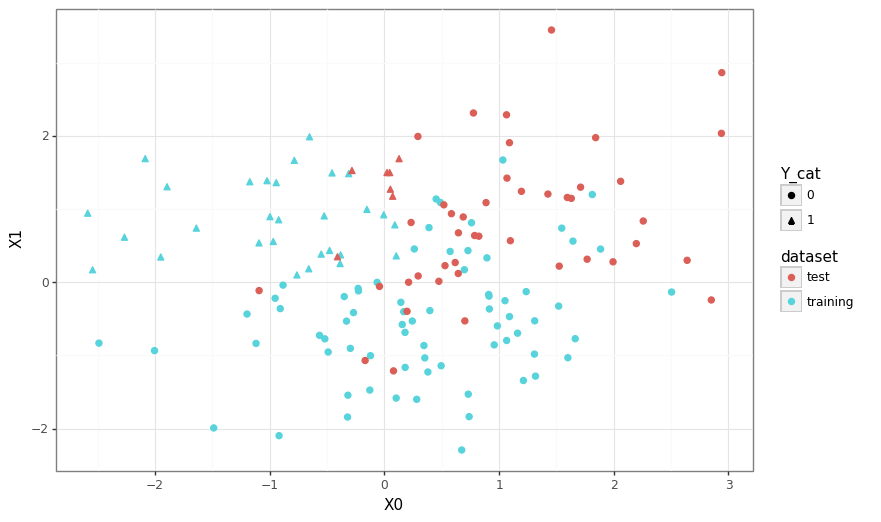

<ggplot: (8730408183223)>

In [3]:
(
    pln.ggplot(data=plot_df, mapping=pln.aes(x="X0", y="X1", shape="Y_cat", color="dataset")) +
    pln.geom_point(size=2) +
    pln.theme_bw() +
    pln.theme(figure_size=(9, 6))
 )

In [4]:
# logical regression from sklearn
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X=plot_df[["X0", "X1"]], y=plot_df["dataset"])

LogisticRegression()

In [5]:
h_x = np.minimum(np.exp(lr.intercept_ + np.matmul(plot_df[["X0", "X1"]].values, lr.coef_.T)), 100)

In [38]:
h_x_train = torch.tensor(np.minimum(np.exp(lr.intercept_ + np.matmul(plot_df[["X0", "X1"]].loc[plot_df["dataset"] == "training"].values, lr.coef_.T)), 100), requires_grad=True)
h_x_test = torch.tensor(np.minimum(np.exp(lr.intercept_ + np.matmul(plot_df[["X0", "X1"]].loc[plot_df["dataset"] == "test"].values, lr.coef_.T)), 100), requires_grad=True)

In [39]:
# update training and test datasets with weights
training_data = (training_data[0], training_data[1], h_x_train)
test_data = (test_data[0], test_data[1], h_x_test)

In [6]:
plot_df = plot_df.assign(weights = 1/h_x)  # assign (reciprocal of) weights

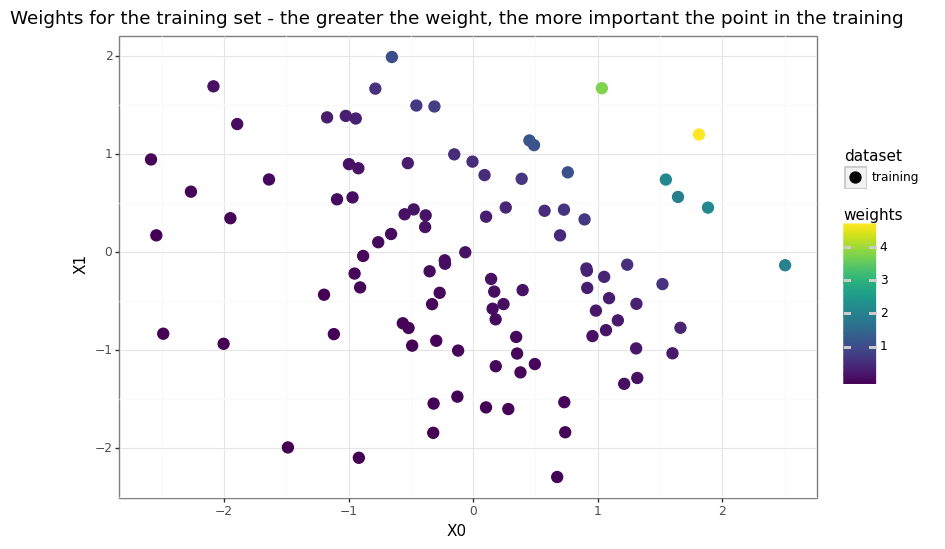

<ggplot: (8730170874998)>

In [7]:
(
    pln.ggplot(data=plot_df.loc[plot_df["dataset"]=="training"], mapping=pln.aes(x="X0", y="X1", shape="dataset", fill="weights", color="weights")) +
    pln.geom_point(size=4) +
    pln.labs(title="Weights for the training set - the greater the weight, the more important the point in the training") +
    pln.theme_bw() +
    pln.theme(figure_size=(9, 6))
)

In [40]:
from torch.utils.data import Dataset, DataLoader

# convert dataset into data loader
class BinaryClassifierDataset(Dataset):

    def __init__(self, train=True):
        super().__init__()
        self.train = train
        if self.train:
            self.dataset = training_data
        else:
            self.dataset = test_data
        
    def __getitem__(self, idx):
        return self.dataset[0][idx], self.dataset[1][idx], self.dataset[2][idx]
    
    def __len__(self):
        return self.dataset[1].shape[0]
    

train_dataloader = DataLoader(BinaryClassifierDataset(train=True), batch_size=32, shuffle=True)
test_dataloader = DataLoader(BinaryClassifierDataset(train=False), batch_size=128, shuffle=False)

In [59]:
## train a neural network with the new weights
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix


class SimpleTwoClassNetWithWeights(nn.Module):
    def __init__(self, input_dim=2, output_dim=2):
        super().__init__()
        self.net = nn.LazyLinear(output_dim)
        

    def forward(self, x):
        return self.net(x)
    
net = SimpleTwoClassNetWithWeights()

loss_fn = nn.CrossEntropyLoss(reduce=None)
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)

/root/PythonProjects/dive-into-deep-learning/.venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.


In [60]:
for epoch in range(5):
    for batch_features, batch_labels, batch_weights in train_dataloader:
        # Step 1. Remember that PyTorch accumulates gradients.
        # We need to clear them out before each instance
        net.zero_grad()

        # Step 2. Run our forward pass.
        logits = net(batch_features)

        # Step 3. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss = loss_fn(logits, batch_labels) #* batch_weights  # weigh the errors with weights calculated previously
        # print(loss_fn(logits, batch_labels))
        # print(loss)
        loss.sum().backward()  # since our loss has multiple elements
        optimizer.step()

In [61]:
with torch.no_grad():
    for batch_features, batch_labels, _ in test_dataloader:
        logits = net(batch_features)
        softmax_of_logits = F.softmax(logits, dim=1)
        classification = torch.argmax(softmax_of_logits, dim=1).detach().numpy()
        print(confusion_matrix(y_pred=classification, y_true=batch_labels.detach().numpy()))

[[37  6]
 [ 1  6]]


In [66]:
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, param.data)

net.weight tensor([[ 1.0603, -1.2185],
        [-0.8743,  1.2154]])
net.bias tensor([ 0.9046, -0.7793])


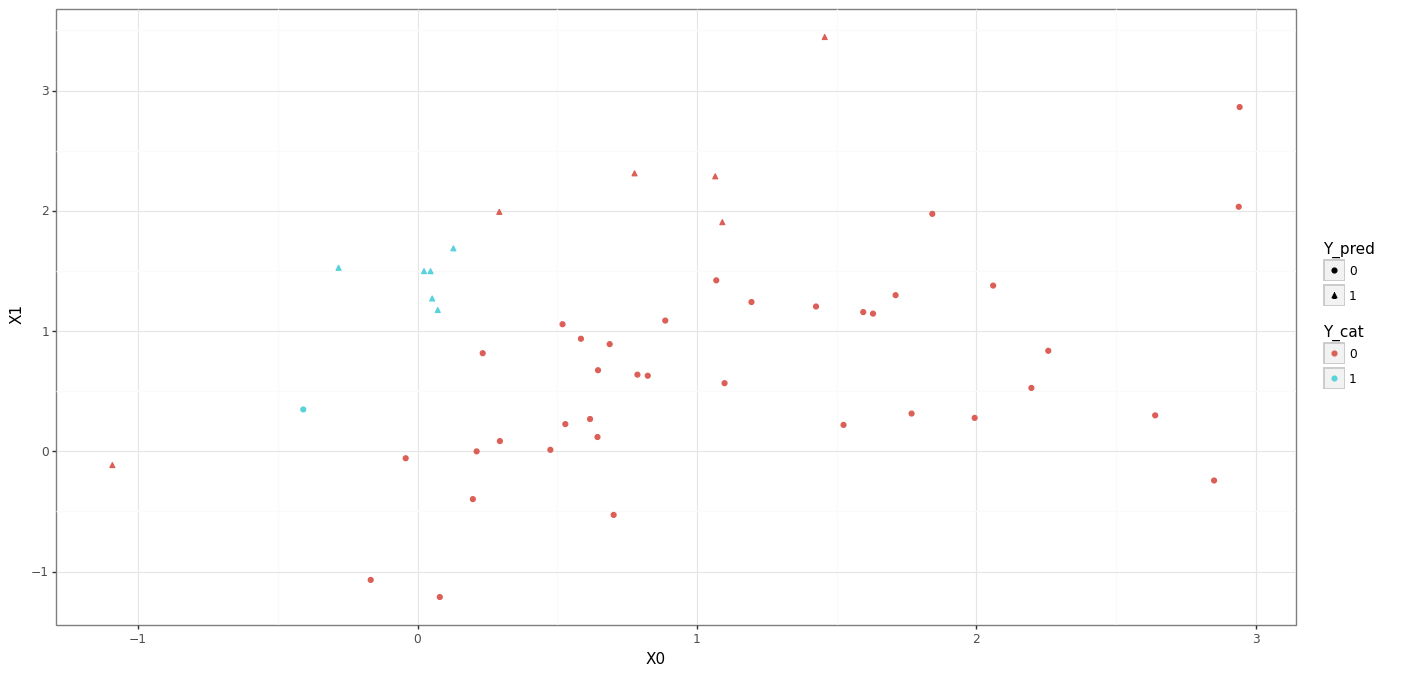

<ggplot: (8730159635450)>

In [62]:
# plot the output of the classification

(
    pln.ggplot(data=plot_df.loc[plot_df["dataset"] == "test"].assign(Y_pred=pd.Categorical(classification, categories=[0.0, 1.0])), 
               mapping=pln.aes(x="X0", y="X1", shape="Y_pred", color="Y_cat", fill="Y_cat")) +
    pln.geom_point() +
    pln.theme_bw() +
    pln.theme(figure_size=(16, 8))
)
